In [1]:
# take 10% of images from each class to validation

In [2]:
# there are B&W images in data!

In [3]:
import os
from datetime import datetime
from typing import Tuple
from time import monotonic

# from torchvision.io import read_image
from torchvision import transforms as T
from torch.utils.data import DataLoader, Dataset

import torch
from torch import nn

from torch import optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# from tqdm.notebook import tqdm
num_cpus = os.cpu_count()
half_cpus = num_cpus // 2

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

### Data

In [4]:
class TinyImageNetDataset(Dataset):
    def __init__(self, 
                 img_dir: str, 
                 annotations: list[Tuple[str, str]],
                 transform=None,
                 augment_transform=None, 
                 target_transform=None):
        self.img_dir = img_dir
        self.annotations = annotations
        self.transform = transform
        self.target_transform = target_transform
        self.augment_transform = augment_transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        file_name, label = self.annotations[idx]
        img_path = os.path.join(self.img_dir, label, 'images', file_name)
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [5]:
# TEMP. check with data
source_folder = '../input/flg-ml-24-cnn/tiny-imagenet-200/train'
from pathlib import Path
img_dir = Path(source_folder)
img_dir.exists()
# for c in img_dir.iterdir():
    # for f in (c / "images").iterdir():
        # print(f)
        # break
    # break

# for class_name in img_dir.iterdir():
    # print(len(list((class_name / "images").iterdir())))


# 

True

In [6]:
# for debugging - will remove
N_CLASSES_TO_USE = 200

source_folder = '../input/flg-ml-24-cnn/tiny-imagenet-200/train'

train_split = []
val_split = []

# TODO ? maybe use cross-validation somehow? Looks like model will never train on last 50 images. Or it is okay?
class_names = os.listdir(source_folder)
for class_name in class_names[:N_CLASSES_TO_USE]:
    file_names = os.listdir(f'{source_folder}/{class_name}/images')
    file_ids = [int(name.split('.')[0].split('_')[1]) for name in file_names]

    train_names = [file_names[i] for i in range(len(file_names)) if file_ids[i] < 450]
    val_names = [file_names[i] for i in range(len(file_names)) if file_ids[i] >= 450]
    # print(f"val_names:{val_names}")

    train_split.extend((name, class_name) for name in train_names)
    val_split.extend((name, class_name) for name in val_names)

In [7]:
print(len(train_split + val_split))
# print(train_split[0])
# print(len(train_split), len(val_split))

100000


In [8]:
# TODO ? why and what we are doing by T.Normalize
# Normalization values for mean and std based on data


temp_dataset = TinyImageNetDataset(source_folder, train_split + val_split, transform=T.ToTensor())
temp_dataloader = DataLoader(temp_dataset, batch_size=128, shuffle=False, num_workers=half_cpus)
mean = torch.zeros(3).to(DEVICE)
std = torch.zeros(3).to(DEVICE)
n_samples = 0

# Iterate through the dataset
for images, _ in temp_dataloader:
    images = images.to(DEVICE)
    # Reshape images to (batch_size, 3, height, width)
    images = images.view(images.size(0), images.size(1), -1)
    n_samples += images.size(0)
    
    # Sum up the pixel values for each channel
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)

# Calculate the mean and standard deviation
mean /= n_samples
std /= n_samples

mean = mean.cpu()
std = std.cpu()

print(f'Mean: {mean}')
print(f'Std: {std}')

train_img_transform = T.Compose([
    T.ToTensor(),
    T.RandomRotation([-30, 30]),
    T.RandomHorizontalFlip(),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    # T.Normalize(mean, std)
])
augment_transform = T.Compose([
    T.RandomHorizontalFlip(p=1.0)  # Always flip the image
])

val_img_transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    # T.Normalize(mean, std)
])

# TODO ? why do we need dict with IDs and back
class_name_to_id_dict = {name: i for i, name in enumerate(class_names)}
class_id_to_name_dict = {i: name for name, i in class_name_to_id_dict.items()}

label_to_id_transform = lambda name: class_name_to_id_dict[name]

Mean: tensor([0.4802, 0.4481, 0.3975])
Std: tensor([0.2296, 0.2263, 0.2255])


In [9]:
train_dataset = TinyImageNetDataset(source_folder,
                                    train_split,
                                    transform=train_img_transform,
                                    target_transform=label_to_id_transform,
                                    augment_transform=augment_transform
                                    )

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=half_cpus)

In [10]:
# TODO ? do we need also to shuffle the val dataset?
val_dataset = TinyImageNetDataset(source_folder,
                                  val_split,
                                  transform=val_img_transform,
                                  target_transform=label_to_id_transform
                                    )

val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=True, num_workers=half_cpus)

In [11]:
# TODO ? what is Y here? why it is 128 values. It should be class value, no?
X, Y = next(iter(train_dataloader))
X.shape, Y.shape

(torch.Size([128, 3, 64, 64]), torch.Size([128]))

---

### Model

In [12]:
# TODO ? just fun, why 42?
def set_seed(seed: int = 42) -> None:
    # np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

def get_number_of_trainable_params(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [13]:
class FcBlock(nn.Module):
    def __init__(self, in_shape: int,
                 out_shape: int,
                 do_batchnorm: bool = True,
                 activation: nn.Module = None):
        super().__init__()
        layers = []

        layers.append(nn.Linear(in_shape, out_shape, bias=not do_batchnorm))

        if activation is not None:
            layers.append(activation)

        if do_batchnorm:
            layers.append(nn.BatchNorm1d(out_shape))

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)


class ResNetBlock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size):
    super().__init__()

    self.main_conv_layer = nn.Sequential(
        nn.Conv2d(in_channels,
                  out_channels,
                  kernel_size=kernel_size,
                  padding=kernel_size // 2,
                  bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        
        nn.Conv2d(out_channels,
                  out_channels,
                  kernel_size=kernel_size,
                  padding=kernel_size // 2,
                  bias=False),
        nn.BatchNorm2d(out_channels),
        # nn.ReLU(),
        
        # nn.Conv2d(out_channels,
        #           out_channels,
        #           kernel_size=kernel_size,
        #           padding=kernel_size // 2,
        #           bias=False),
        # nn.BatchNorm2d(out_channels),
    )

    if in_channels != out_channels:
        self.identity_conv_layer = nn.Sequential(
            nn.Conv2d(in_channels,
                      out_channels,
                      kernel_size=1,
                      padding=0,
                      bias=False),
            nn.BatchNorm2d(out_channels)
        )
    else:
        self.identity_conv_layer = None

    self.relu = nn.ReLU()
    self.pool = nn.MaxPool2d(2, 2)
    
  def forward(self, x):
    y = self.main_conv_layer(x)
    if self.identity_conv_layer is not None:
        x = self.identity_conv_layer(x)
    
    y += x
    y = self.relu(y)
    y = self.pool(y)
    return y

In [14]:
# 3x64x64 -> (conv1) -> 32x32x32 -> (conv2) -> 64x16x16 -> (conv3) -> 128x8x8 -> (conv4) -> 64x4x4=1024

In [15]:
class ResNetModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = ResNetBlock(3, 16, kernel_size=3)
        self.conv2 = ResNetBlock(16, 32, kernel_size=3)
        self.conv3 = ResNetBlock(32, 64, kernel_size=3)
        self.conv4 = ResNetBlock(64, 64, kernel_size=3)

        self.drop1 = nn.Dropout(p=0.2)
        self.fc1 = FcBlock(64 * 4 * 4, 512, do_batchnorm=True, activation=nn.ReLU())

        self.drop2 = nn.Dropout(p=0.1)
        self.fc2 = FcBlock(512, 200, do_batchnorm=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        x = torch.flatten(x, 1)

        x = self.drop1(x)
        x = self.fc1(x)

        x = self.drop2(x)
        x = self.fc2(x)
        return x

---

### Train

In [16]:
# DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
# DEVICE

In [17]:
set_seed(123)

model = ResNetModel()
print(get_number_of_trainable_params(model))

for layer in model.named_parameters():
    print(layer[0], layer[1].numel())

model.to(DEVICE)

Random seed set as 123
777232
conv1.main_conv_layer.0.weight 432
conv1.main_conv_layer.1.weight 16
conv1.main_conv_layer.1.bias 16
conv1.main_conv_layer.3.weight 2304
conv1.main_conv_layer.4.weight 16
conv1.main_conv_layer.4.bias 16
conv1.identity_conv_layer.0.weight 48
conv1.identity_conv_layer.1.weight 16
conv1.identity_conv_layer.1.bias 16
conv2.main_conv_layer.0.weight 4608
conv2.main_conv_layer.1.weight 32
conv2.main_conv_layer.1.bias 32
conv2.main_conv_layer.3.weight 9216
conv2.main_conv_layer.4.weight 32
conv2.main_conv_layer.4.bias 32
conv2.identity_conv_layer.0.weight 512
conv2.identity_conv_layer.1.weight 32
conv2.identity_conv_layer.1.bias 32
conv3.main_conv_layer.0.weight 18432
conv3.main_conv_layer.1.weight 64
conv3.main_conv_layer.1.bias 64
conv3.main_conv_layer.3.weight 36864
conv3.main_conv_layer.4.weight 64
conv3.main_conv_layer.4.bias 64
conv3.identity_conv_layer.0.weight 2048
conv3.identity_conv_layer.1.weight 64
conv3.identity_conv_layer.1.bias 64
conv4.main_conv_la

ResNetModel(
  (conv1): ResNetBlock(
    (main_conv_layer): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (identity_conv_layer): Sequential(
      (0): Conv2d(3, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): ResNetBlock(
    (main_conv_layer): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_

In [18]:
train_config = {
    'n_epochs': 100,
    'lr': 0.01,
    'batch_size': 4096,
}

optimizer = optim.Adam(model.parameters(), lr=train_config['lr'],)
scheduler = ReduceLROnPlateau(optimizer, patience=1, factor=0.5, verbose="True")
criterion = nn.CrossEntropyLoss()

train_dataloader = DataLoader(train_dataset, batch_size=train_config['batch_size'], shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=train_config['batch_size'], shuffle=False)

best_checkpoint_path = '../working/best.pth'

/home/vpashchenkov/mine/flg_ml24-cnn/.venv/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [19]:
def do_train_epoch(model: nn.Module, 
                   criterion: nn.Module,
                   optimizer,
                   train_loader: DataLoader, 
                   verbose: int = -1) -> Tuple[float, float]:
    total_steps = len(train_dataloader)
    
    running_loss, step = 0, 0
    n_correct_predictions, total_predictions = 0, 0
    for X, Y in train_loader:
        X = X.to(DEVICE)
        Y = Y.to(DEVICE)
        optimizer.zero_grad()
    
        preds = model(X)
        loss = criterion(preds, Y)
        loss.backward()
        optimizer.step()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
    
        running_loss += loss.item()
        step += 1

        if verbose > 0 and step % verbose == 0:
            cur_time = datetime.now().strftime("%H:%M:%S")
            print(f"[{cur_time}] Step {step}/{total_steps}: train loss = {round(running_loss / step, 5)}")

        total_predictions += len(Y)

        probs = F.softmax(preds, dim=1)
        predicted_labels = torch.argmax(probs, dim=1)
        n_correct_predictions += (predicted_labels == Y).sum().item()
    
    avg_loss = round(running_loss / step, 5)
    accuracy = round(n_correct_predictions / total_predictions, 5)
    print(f"Train loss = {avg_loss}, accuracy = {accuracy}, lr: {optimizer.param_groups[0]['lr']}")
    return avg_loss, accuracy

In [20]:
def do_val_epoch(model: nn.Module,
                 criterion: nn.Module,
                 val_loader: DataLoader) -> Tuple[float, float]:
    total_steps = len(val_loader)
    
    running_loss = 0
    n_correct_predictions, total_predictions = 0, 0
    
    with torch.no_grad():
        for X, Y in val_loader:
            X = X.to(DEVICE)
            Y = Y.to(DEVICE)
            preds = model(X)
            loss = criterion(preds, Y)
    
            running_loss += loss.item()
            total_predictions += len(Y)
    
            probs = F.softmax(preds, dim=1)
            predicted_labels = torch.argmax(probs, dim=1)
            n_correct_predictions += (predicted_labels == Y).sum().item()

    avg_loss = round(running_loss / total_steps, 5)
    accuracy = round(n_correct_predictions / total_predictions, 5)

    print(f'VALIDATION LOSS = {avg_loss}, VALIDATION ACCURACY = {accuracy}')
    
    return avg_loss, accuracy
          

In [21]:
def plot_history(history: dict):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    
    ax[0].plot(history['train_loss'], marker='o', label='Train Loss')
    ax[0].plot(history['test_loss'], marker='o', label='Test Loss')
    ax[0].set_title('Loss per epoch')
    ax[0].legend()
    
    ax[1].plot(history['train_accuracy'], marker='o', label='Train Accuracy')
    ax[1].plot(history['test_accuracy'], marker='o', label='Test Accuracy')
    ax[1].set_title('Accuracy per epoch')
    ax[1].legend()
    
    plt.show()


 		 ------------------------------ EPOCH: 1 ------------------------------


[01:26:38] Step 20/22: train loss = 4.87856
Train loss = 4.84613, accuracy = 0.05581, lr: 0.01
VALIDATION LOSS = 4.78881, VALIDATION ACCURACY = 0.0619
LR: [0.01]


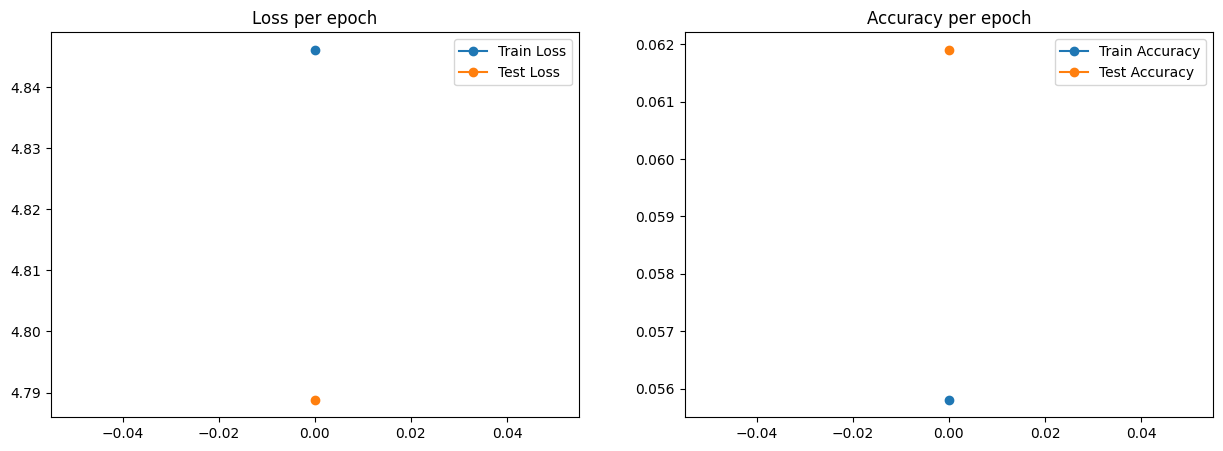

Saving best model

 		 ------------------------------ EPOCH: 2 ------------------------------
[01:27:56] Step 20/22: train loss = 4.32433
Train loss = 4.31097, accuracy = 0.11732, lr: 0.01
VALIDATION LOSS = 4.28999, VALIDATION ACCURACY = 0.1183
LR: [0.01]


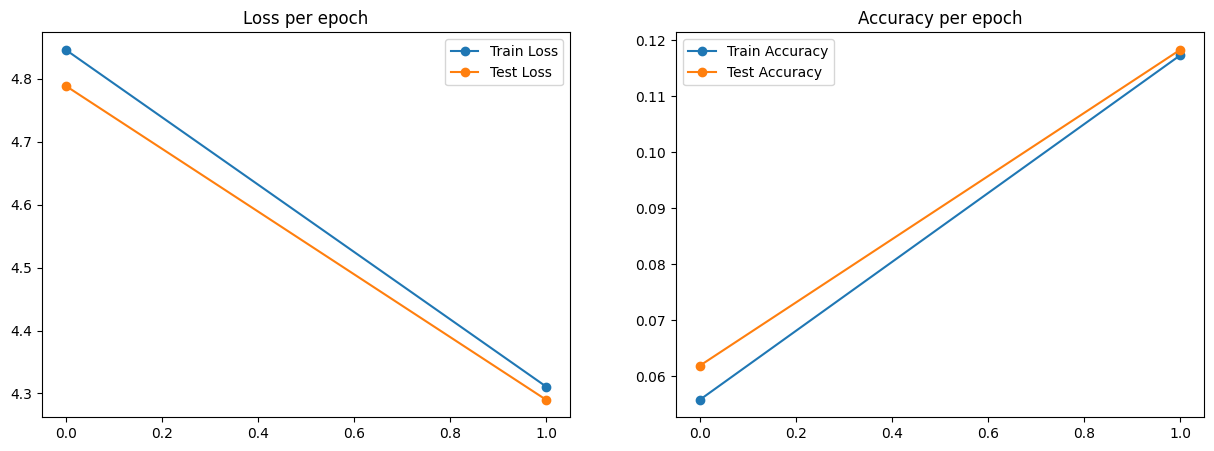

Saving best model

 		 ------------------------------ EPOCH: 3 ------------------------------
[01:29:11] Step 20/22: train loss = 4.01263
Train loss = 3.99961, accuracy = 0.16024, lr: 0.01
VALIDATION LOSS = 3.89536, VALIDATION ACCURACY = 0.1746
LR: [0.01]


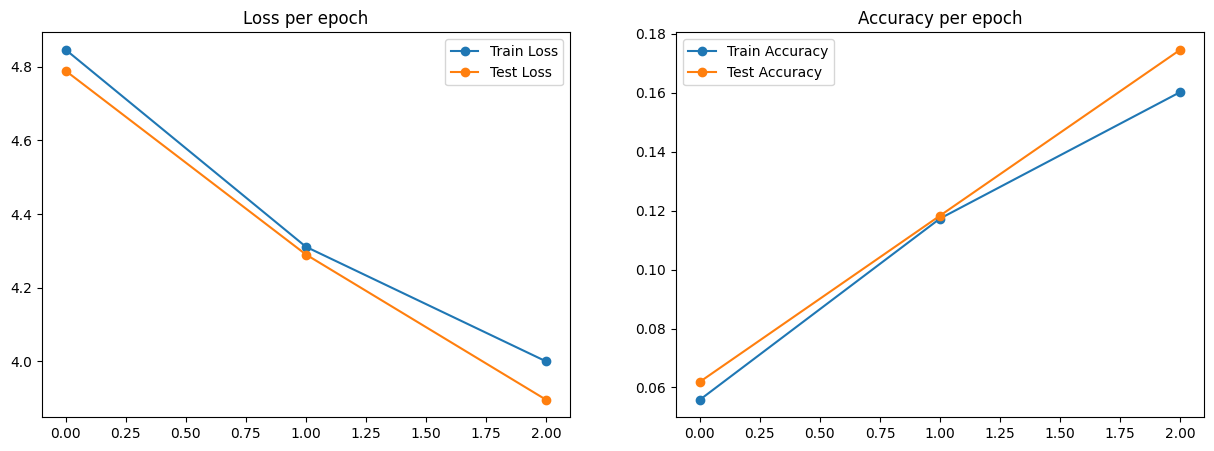

Saving best model

 		 ------------------------------ EPOCH: 4 ------------------------------
[01:30:32] Step 20/22: train loss = 3.74816
Train loss = 3.73885, accuracy = 0.19592, lr: 0.01
VALIDATION LOSS = 3.72241, VALIDATION ACCURACY = 0.2043
LR: [0.01]


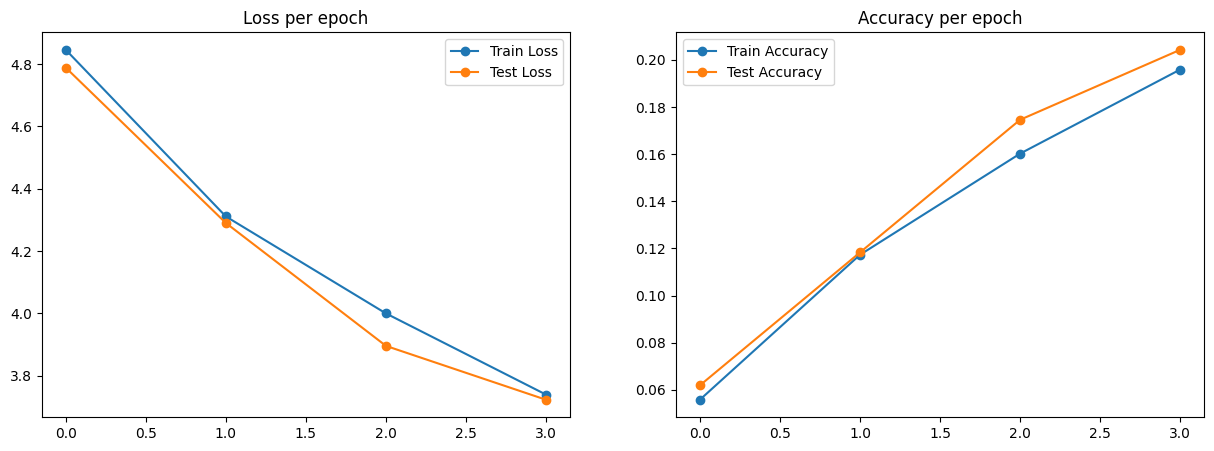

Saving best model

 		 ------------------------------ EPOCH: 5 ------------------------------
[01:31:52] Step 20/22: train loss = 3.53112
Train loss = 3.5267, accuracy = 0.22462, lr: 0.01
VALIDATION LOSS = 3.65682, VALIDATION ACCURACY = 0.2112
LR: [0.01]


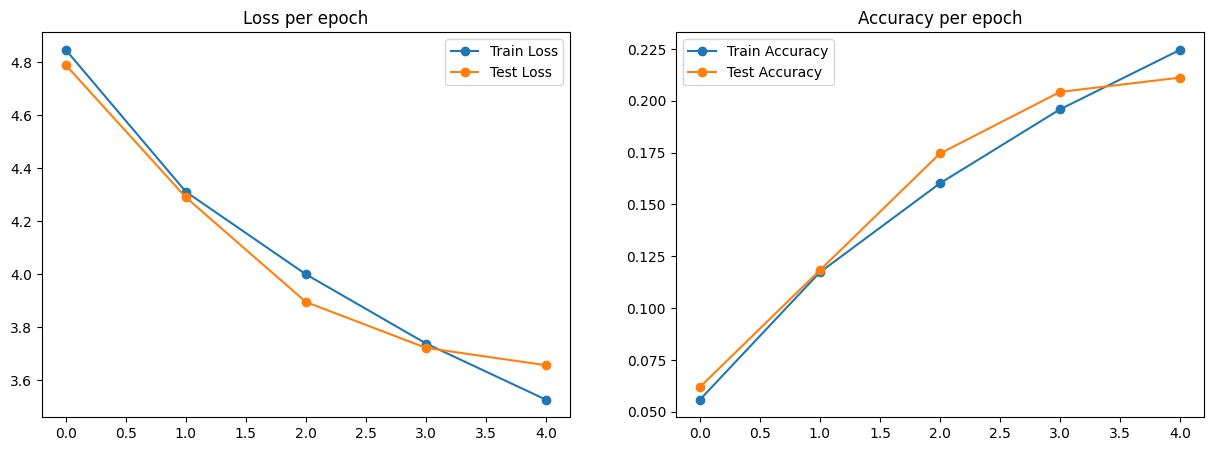

Saving best model

 		 ------------------------------ EPOCH: 6 ------------------------------
[01:33:10] Step 20/22: train loss = 3.37466
Train loss = 3.36845, accuracy = 0.25028, lr: 0.01
VALIDATION LOSS = 3.54884, VALIDATION ACCURACY = 0.2276
LR: [0.01]


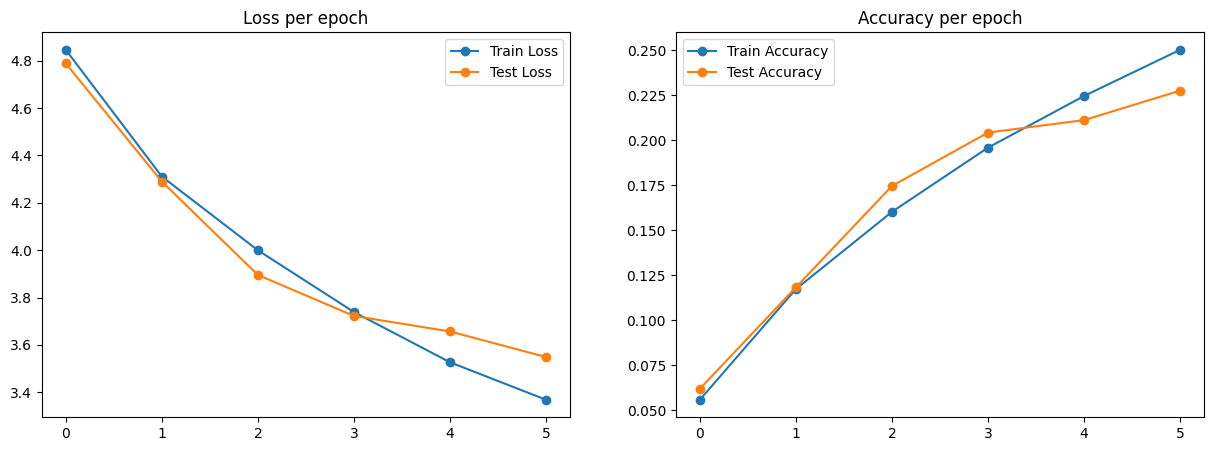

Saving best model

 		 ------------------------------ EPOCH: 7 ------------------------------
[01:34:29] Step 20/22: train loss = 3.22795
Train loss = 3.22368, accuracy = 0.27363, lr: 0.01
VALIDATION LOSS = 3.21128, VALIDATION ACCURACY = 0.2859
LR: [0.01]


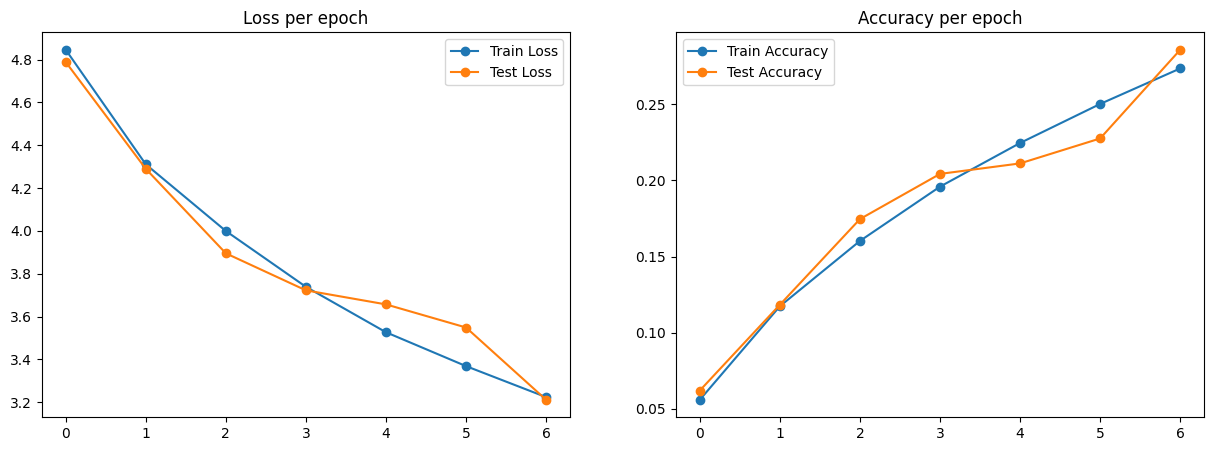

Saving best model

 		 ------------------------------ EPOCH: 8 ------------------------------
[01:35:48] Step 20/22: train loss = 3.10919
Train loss = 3.1092, accuracy = 0.29289, lr: 0.01
VALIDATION LOSS = 3.24434, VALIDATION ACCURACY = 0.3023
LR: [0.01]


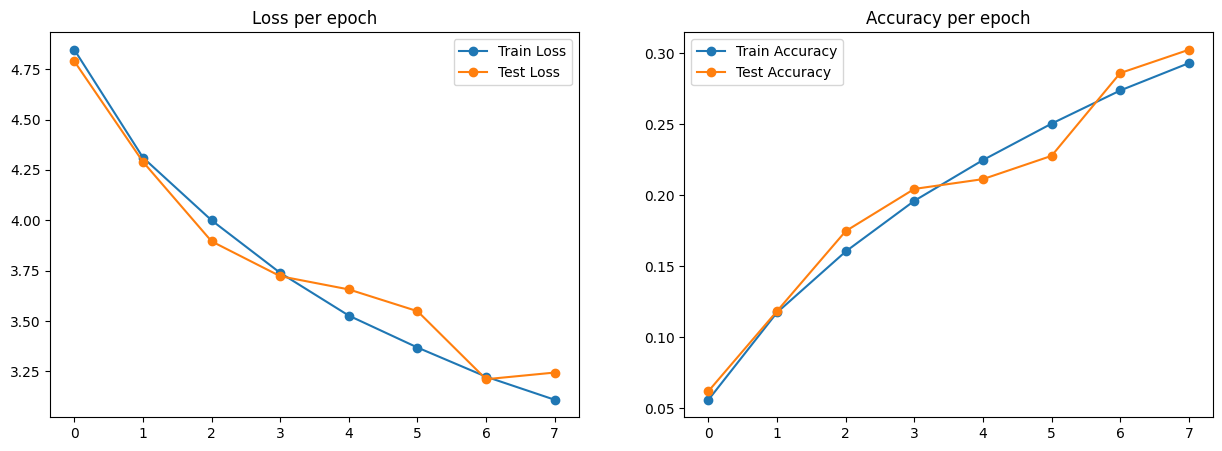

Validation loss didn't improve

 		 ------------------------------ EPOCH: 9 ------------------------------
[01:37:06] Step 20/22: train loss = 3.00099
Train loss = 3.00596, accuracy = 0.31158, lr: 0.01
VALIDATION LOSS = 3.14995, VALIDATION ACCURACY = 0.2908
LR: [0.01]


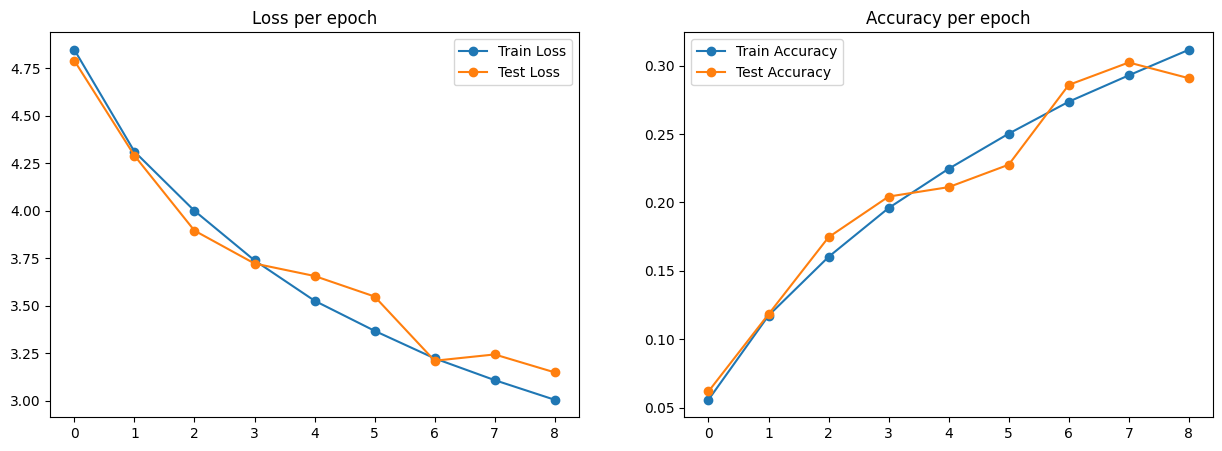

Saving best model

 		 ------------------------------ EPOCH: 10 ------------------------------
[01:38:26] Step 20/22: train loss = 2.93532
Train loss = 2.93621, accuracy = 0.32408, lr: 0.01
VALIDATION LOSS = 3.13316, VALIDATION ACCURACY = 0.2945
LR: [0.01]


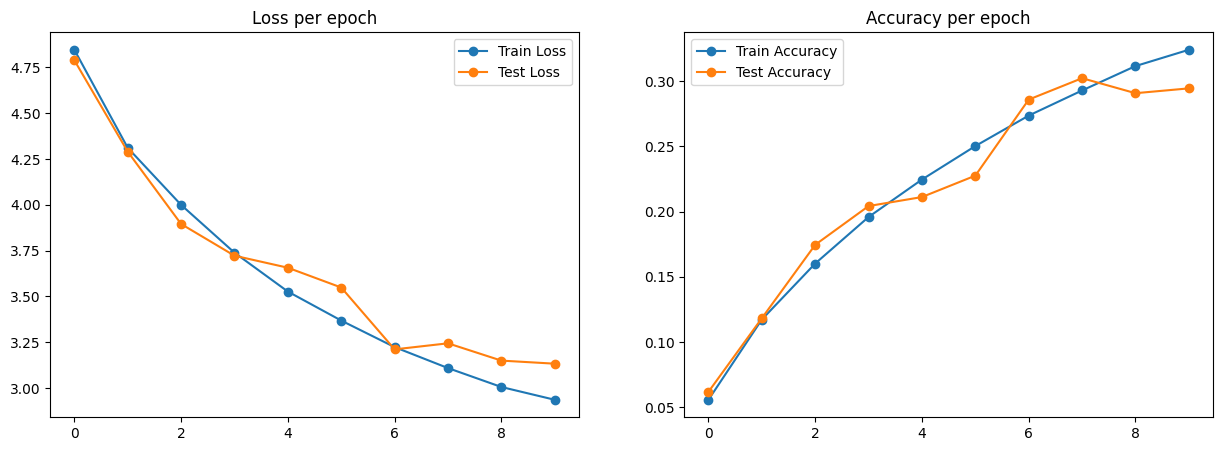

Saving best model

 		 ------------------------------ EPOCH: 11 ------------------------------
[01:39:47] Step 20/22: train loss = 2.86699
Train loss = 2.87049, accuracy = 0.33567, lr: 0.01
VALIDATION LOSS = 3.04016, VALIDATION ACCURACY = 0.3149
LR: [0.01]


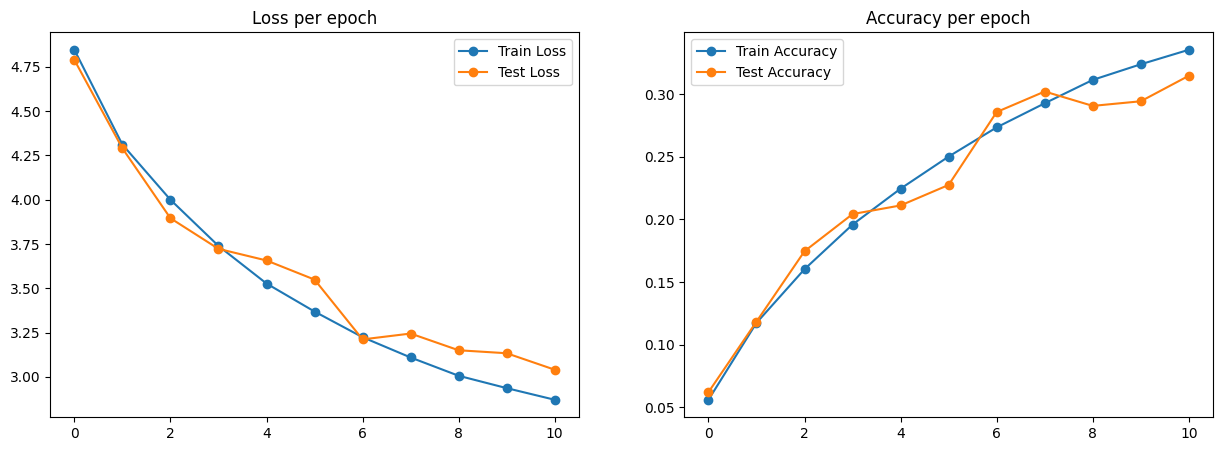

Saving best model

 		 ------------------------------ EPOCH: 12 ------------------------------
[01:41:08] Step 20/22: train loss = 2.81798
Train loss = 2.81809, accuracy = 0.34298, lr: 0.01
VALIDATION LOSS = 2.95704, VALIDATION ACCURACY = 0.3297
LR: [0.01]


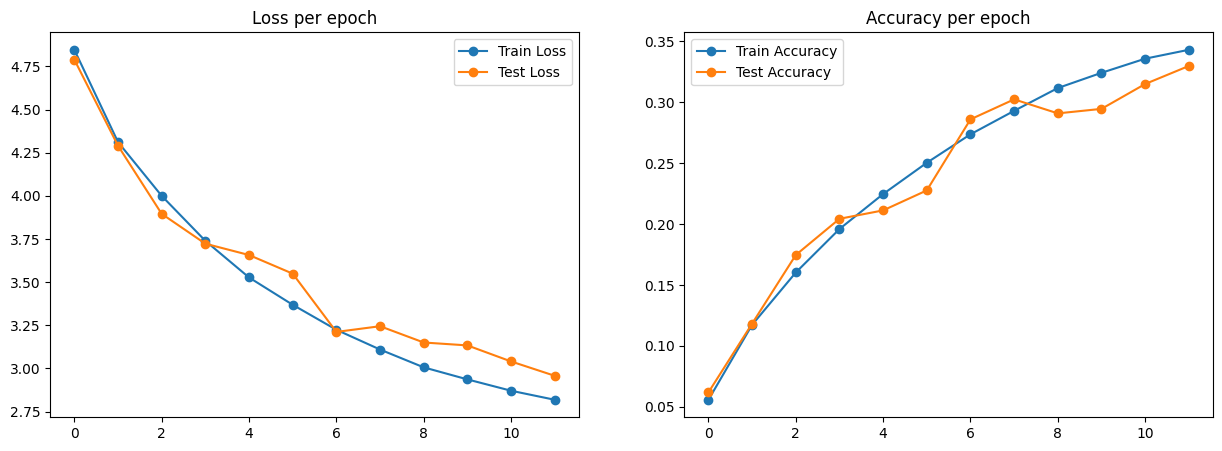

Saving best model

 		 ------------------------------ EPOCH: 13 ------------------------------
[01:42:29] Step 20/22: train loss = 2.75451
Train loss = 2.75283, accuracy = 0.35478, lr: 0.01
VALIDATION LOSS = 3.02967, VALIDATION ACCURACY = 0.3234
LR: [0.01]


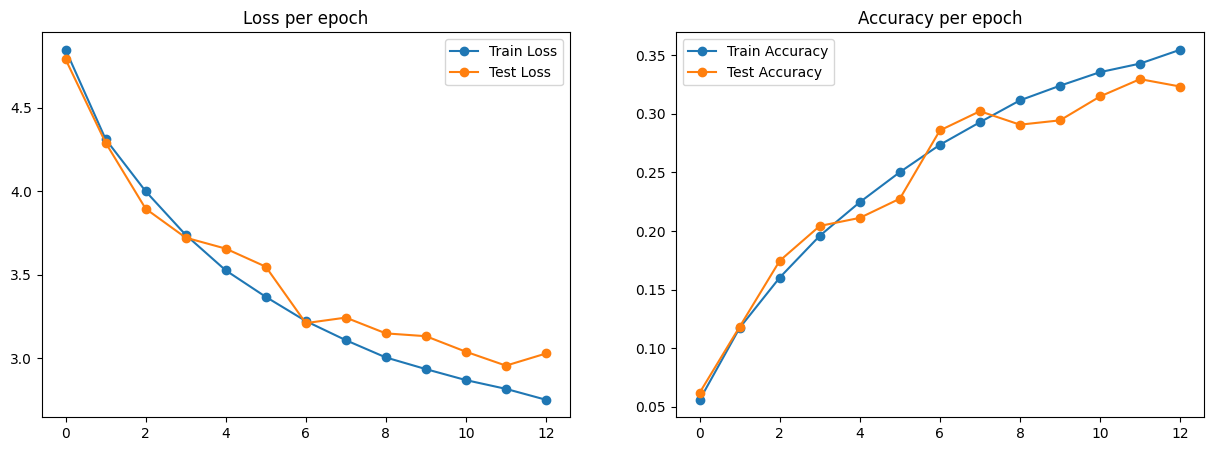

Validation loss didn't improve

 		 ------------------------------ EPOCH: 14 ------------------------------
[01:43:52] Step 20/22: train loss = 2.69451
Train loss = 2.69746, accuracy = 0.36636, lr: 0.01
VALIDATION LOSS = 2.89503, VALIDATION ACCURACY = 0.3415
LR: [0.01]


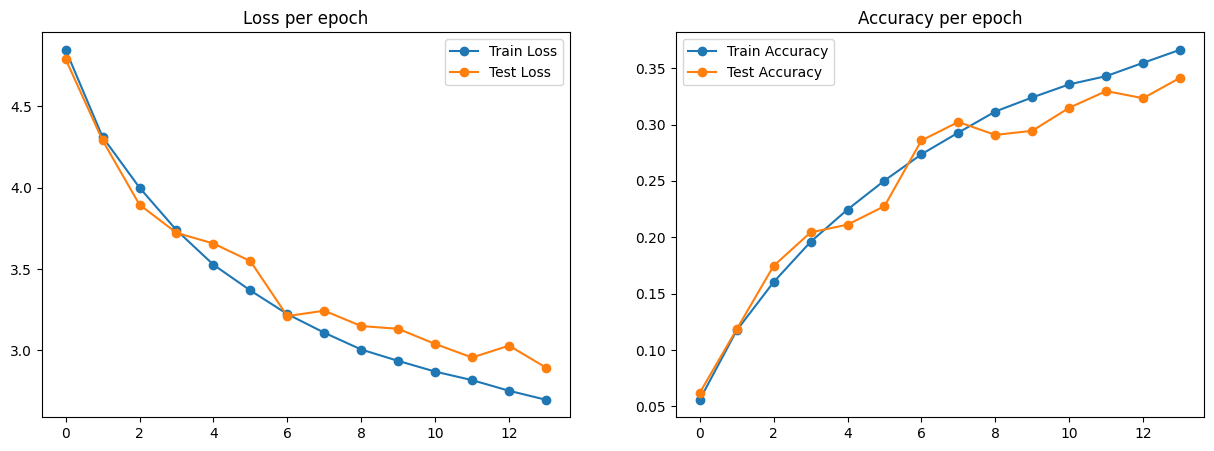

Saving best model

 		 ------------------------------ EPOCH: 15 ------------------------------
[01:45:15] Step 20/22: train loss = 2.65414
Train loss = 2.65624, accuracy = 0.37302, lr: 0.01
VALIDATION LOSS = 2.79789, VALIDATION ACCURACY = 0.3587
LR: [0.01]


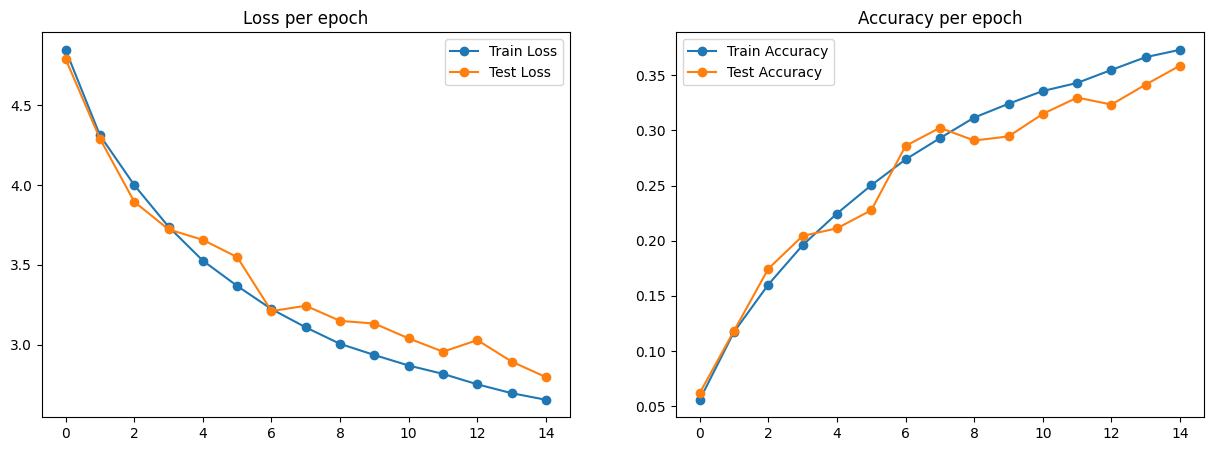

Saving best model

 		 ------------------------------ EPOCH: 16 ------------------------------
[01:47:25] Step 20/22: train loss = 2.6144
Train loss = 2.61541, accuracy = 0.38109, lr: 0.01
VALIDATION LOSS = 2.88231, VALIDATION ACCURACY = 0.3454
LR: [0.01]


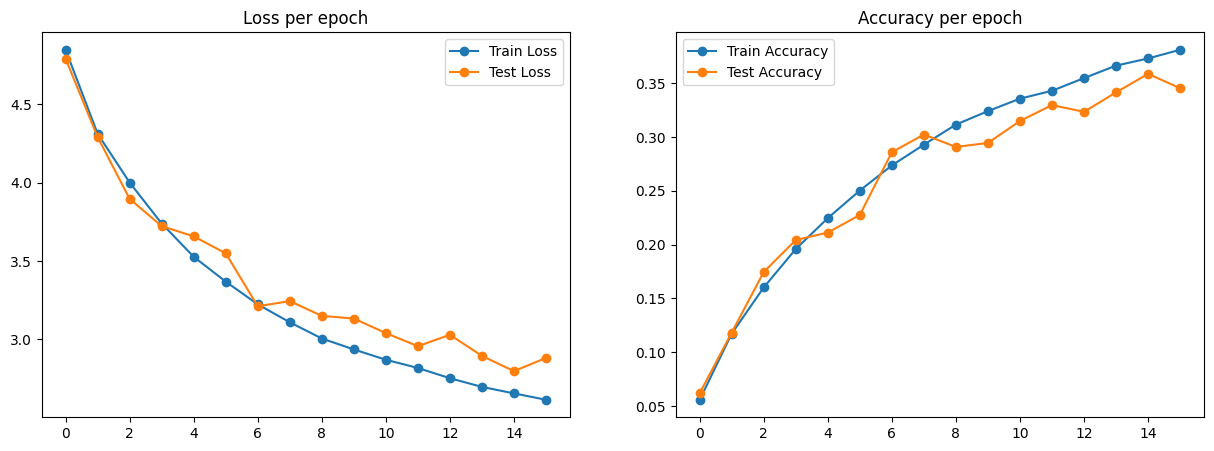

Validation loss didn't improve

 		 ------------------------------ EPOCH: 17 ------------------------------
[01:49:33] Step 20/22: train loss = 2.57608
Train loss = 2.57856, accuracy = 0.38856, lr: 0.01
VALIDATION LOSS = 2.81985, VALIDATION ACCURACY = 0.3559
LR: [0.005]


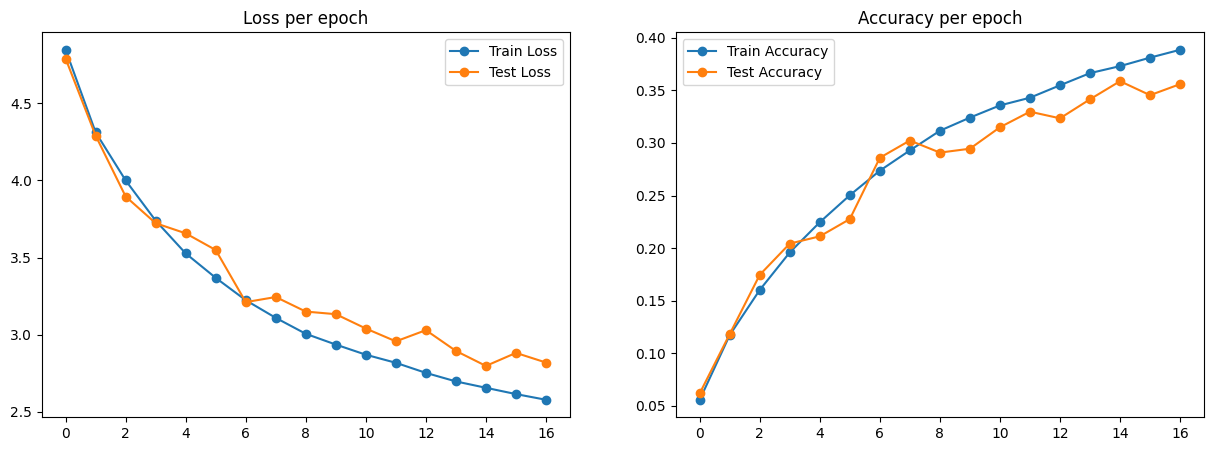

Validation loss didn't improve

 		 ------------------------------ EPOCH: 18 ------------------------------
[01:51:43] Step 20/22: train loss = 2.48808
Train loss = 2.49021, accuracy = 0.40366, lr: 0.005
VALIDATION LOSS = 2.67887, VALIDATION ACCURACY = 0.384
LR: [0.005]


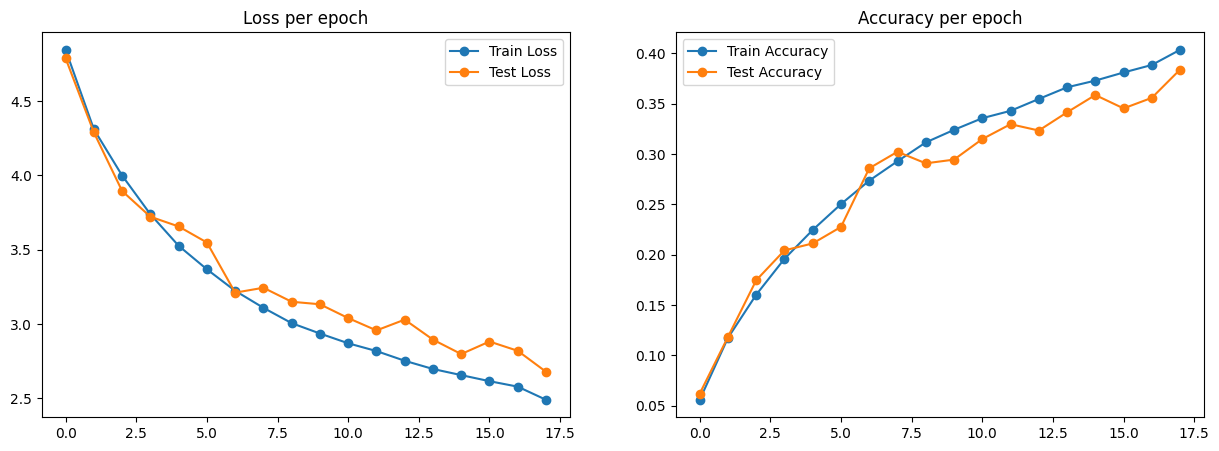

Saving best model

 		 ------------------------------ EPOCH: 19 ------------------------------
[01:53:36] Step 20/22: train loss = 2.4301
Train loss = 2.43551, accuracy = 0.41614, lr: 0.005
VALIDATION LOSS = 2.68444, VALIDATION ACCURACY = 0.3838
LR: [0.005]


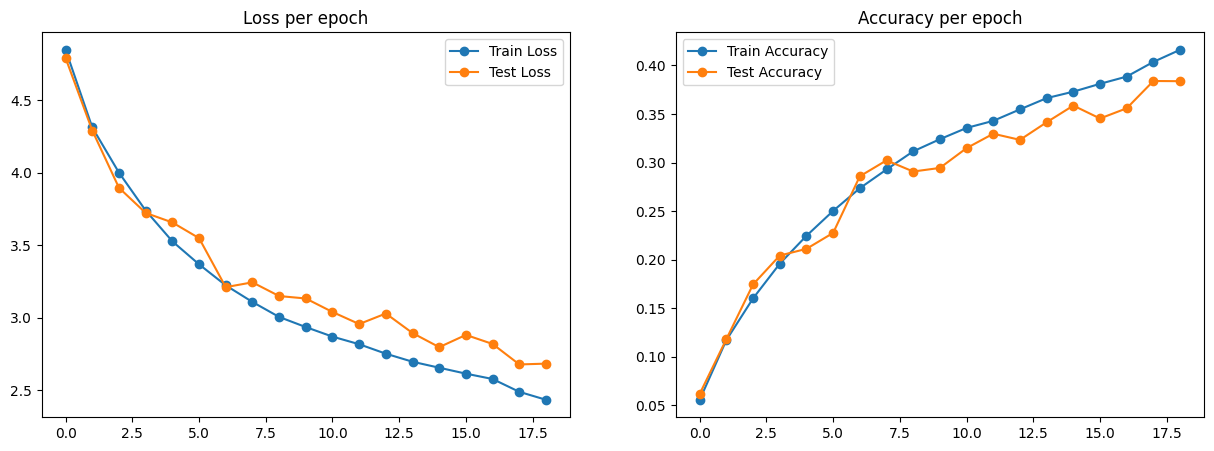

Validation loss didn't improve

 		 ------------------------------ EPOCH: 20 ------------------------------
[01:55:00] Step 20/22: train loss = 2.41863
Train loss = 2.41811, accuracy = 0.41878, lr: 0.005
VALIDATION LOSS = 2.69505, VALIDATION ACCURACY = 0.3813
LR: [0.0025]


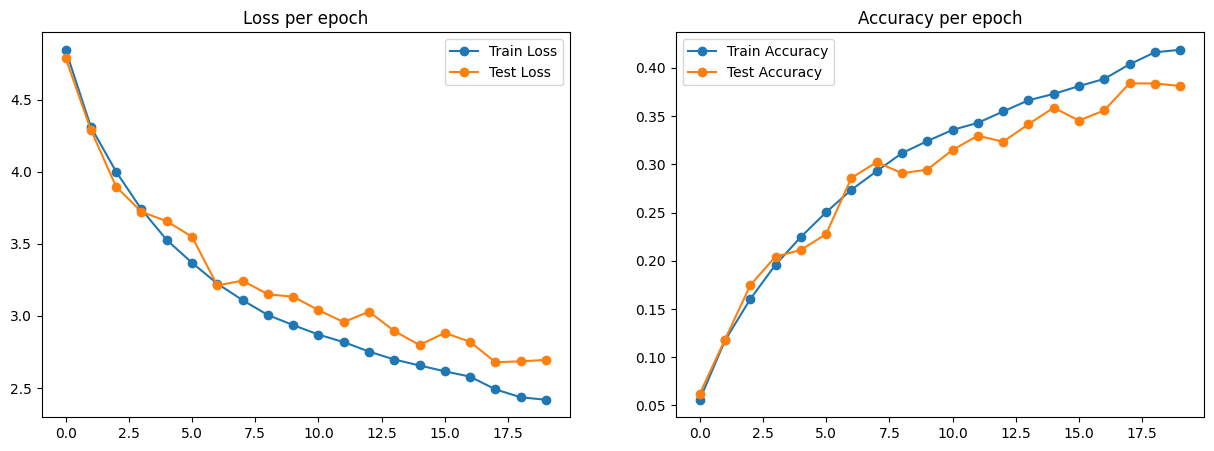

Validation loss didn't improve

 		 ------------------------------ EPOCH: 21 ------------------------------
[01:56:19] Step 20/22: train loss = 2.35964
Train loss = 2.36141, accuracy = 0.43031, lr: 0.0025
VALIDATION LOSS = 2.5824, VALIDATION ACCURACY = 0.4064
LR: [0.0025]


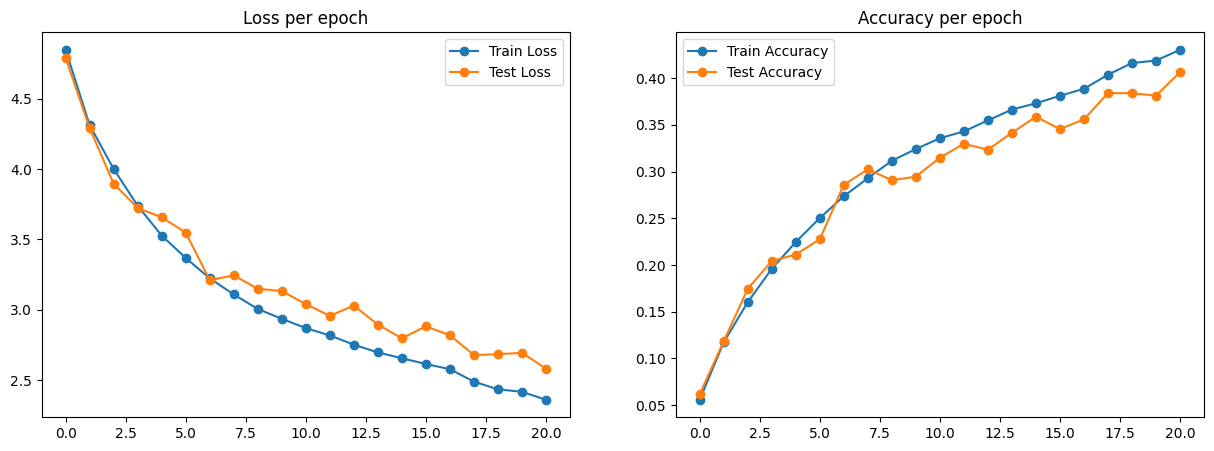

Saving best model

 		 ------------------------------ EPOCH: 22 ------------------------------
[01:57:36] Step 20/22: train loss = 2.32701
Train loss = 2.33015, accuracy = 0.4375, lr: 0.0025
VALIDATION LOSS = 2.61101, VALIDATION ACCURACY = 0.4006
LR: [0.0025]


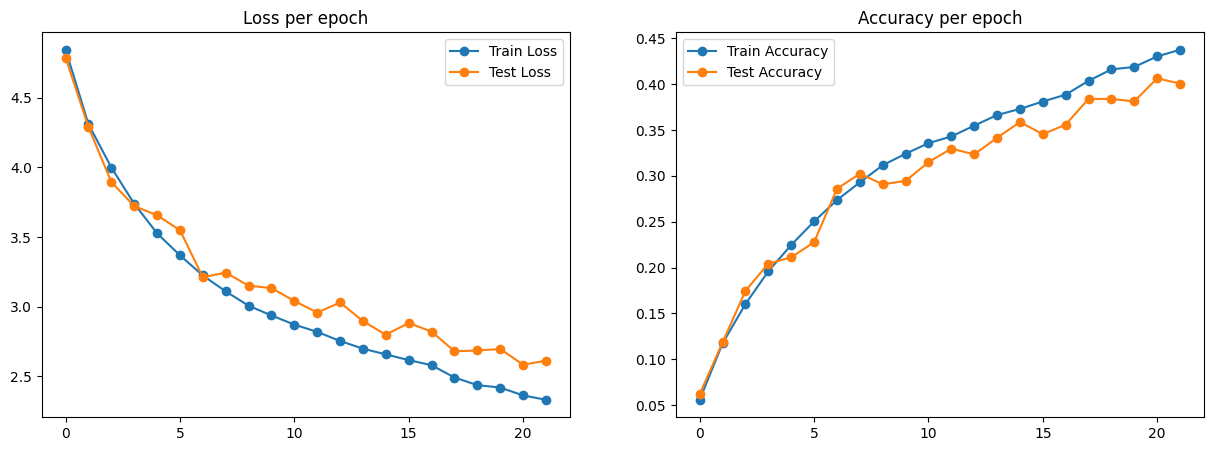

Validation loss didn't improve

 		 ------------------------------ EPOCH: 23 ------------------------------
[01:58:59] Step 20/22: train loss = 2.31981
Train loss = 2.32154, accuracy = 0.43797, lr: 0.0025
VALIDATION LOSS = 2.56675, VALIDATION ACCURACY = 0.406
LR: [0.0025]


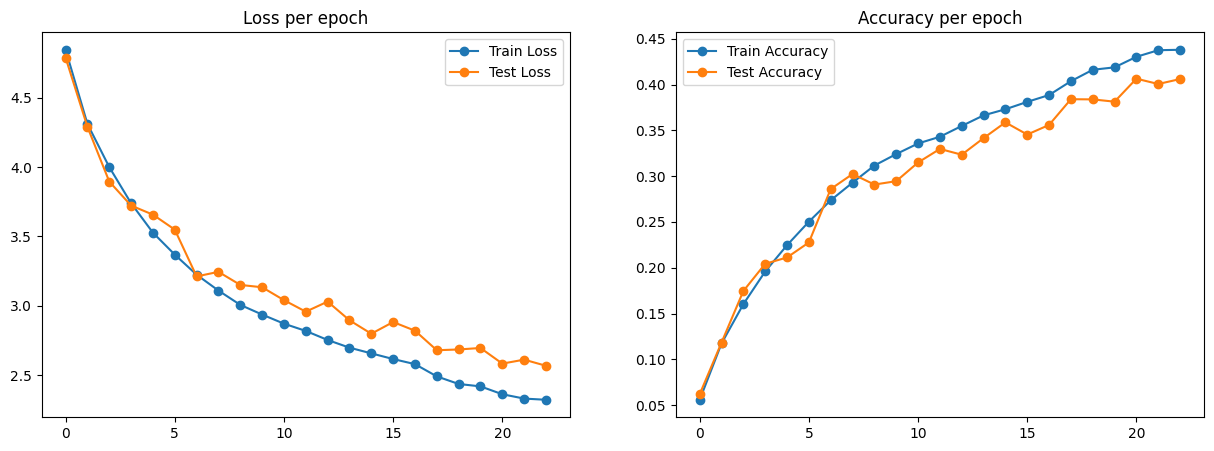

Saving best model

 		 ------------------------------ EPOCH: 24 ------------------------------
[02:00:20] Step 20/22: train loss = 2.30923
Train loss = 2.30913, accuracy = 0.4405, lr: 0.0025
VALIDATION LOSS = 2.58804, VALIDATION ACCURACY = 0.4022
LR: [0.0025]


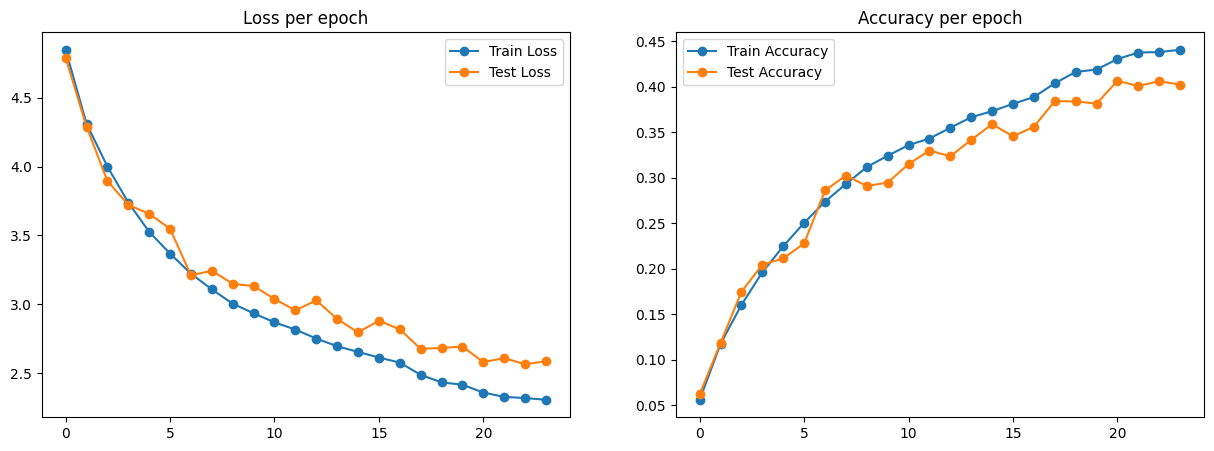

Validation loss didn't improve

 		 ------------------------------ EPOCH: 25 ------------------------------
[02:01:41] Step 20/22: train loss = 2.29393
Train loss = 2.29473, accuracy = 0.44371, lr: 0.0025
VALIDATION LOSS = 2.55231, VALIDATION ACCURACY = 0.4086
LR: [0.0025]


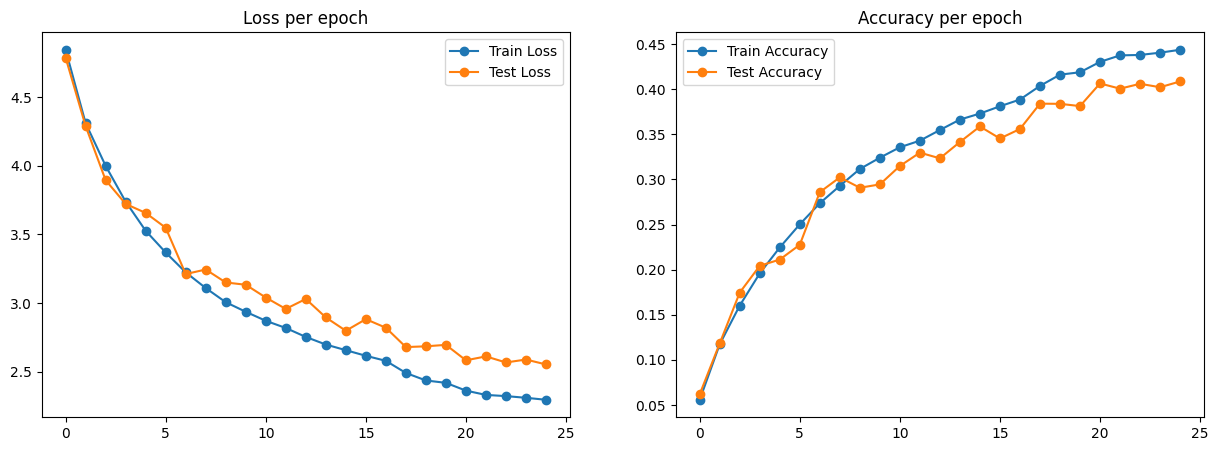

Saving best model

 		 ------------------------------ EPOCH: 26 ------------------------------
[02:03:06] Step 20/22: train loss = 2.27958
Train loss = 2.28338, accuracy = 0.44751, lr: 0.0025
VALIDATION LOSS = 2.58789, VALIDATION ACCURACY = 0.4014
LR: [0.0025]


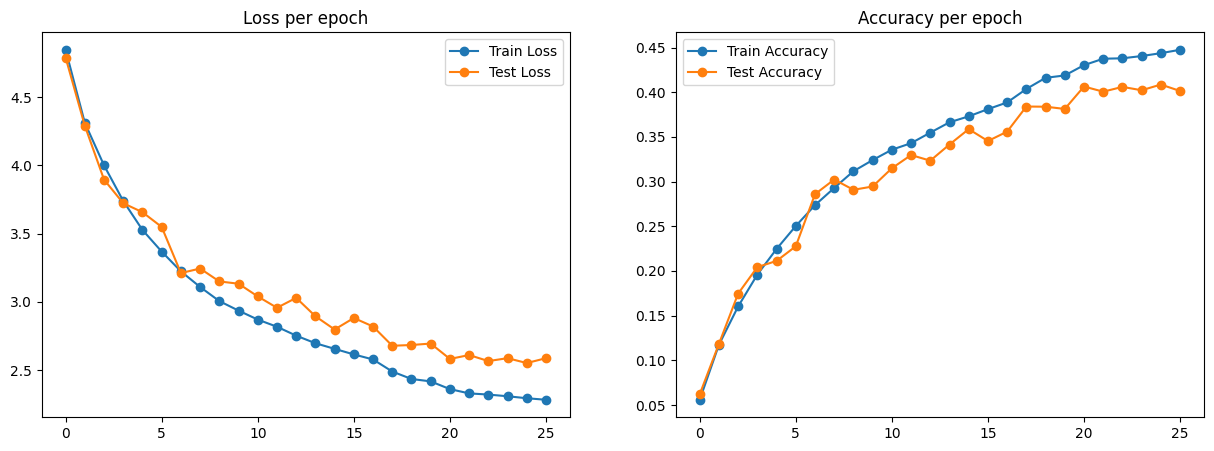

Validation loss didn't improve

 		 ------------------------------ EPOCH: 27 ------------------------------
[02:04:23] Step 20/22: train loss = 2.27943
Train loss = 2.2792, accuracy = 0.44553, lr: 0.0025
VALIDATION LOSS = 2.59104, VALIDATION ACCURACY = 0.4012
LR: [0.00125]


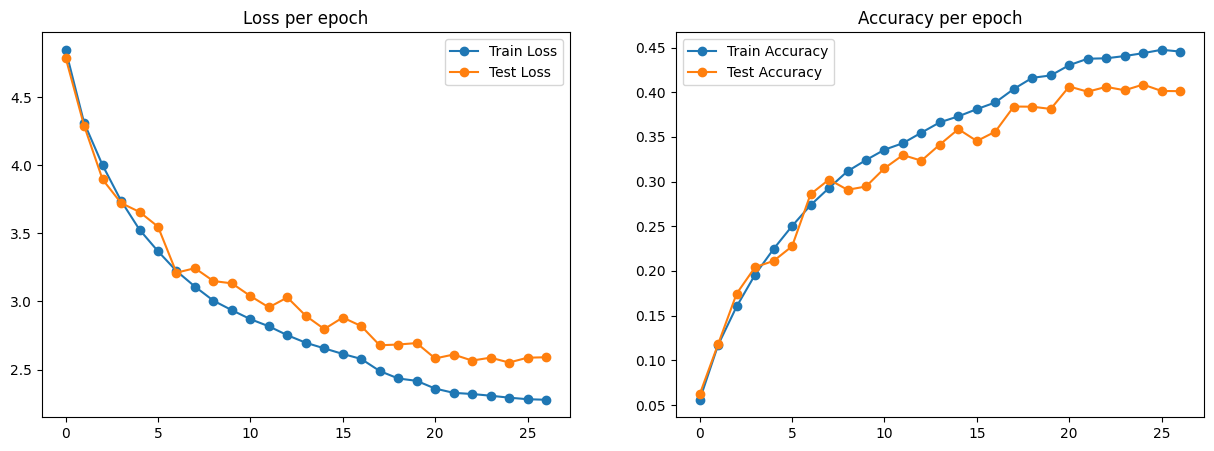

Validation loss didn't improve

 		 ------------------------------ EPOCH: 28 ------------------------------
[02:05:43] Step 20/22: train loss = 2.24319
Train loss = 2.24561, accuracy = 0.45376, lr: 0.00125
VALIDATION LOSS = 2.55013, VALIDATION ACCURACY = 0.4099
LR: [0.00125]


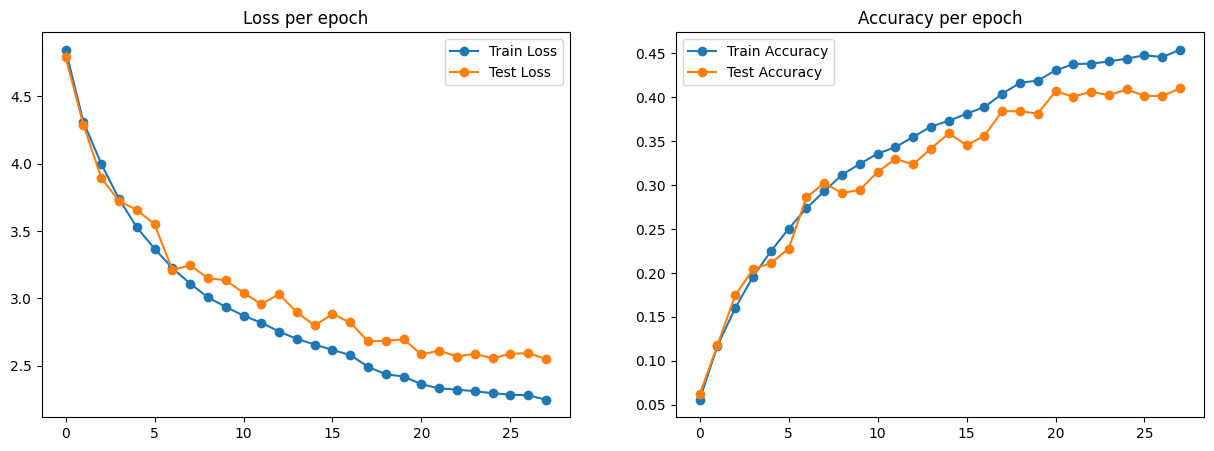

Saving best model

 		 ------------------------------ EPOCH: 29 ------------------------------
[02:07:08] Step 20/22: train loss = 2.22849
Train loss = 2.22972, accuracy = 0.45817, lr: 0.00125
VALIDATION LOSS = 2.53814, VALIDATION ACCURACY = 0.4132
LR: [0.00125]


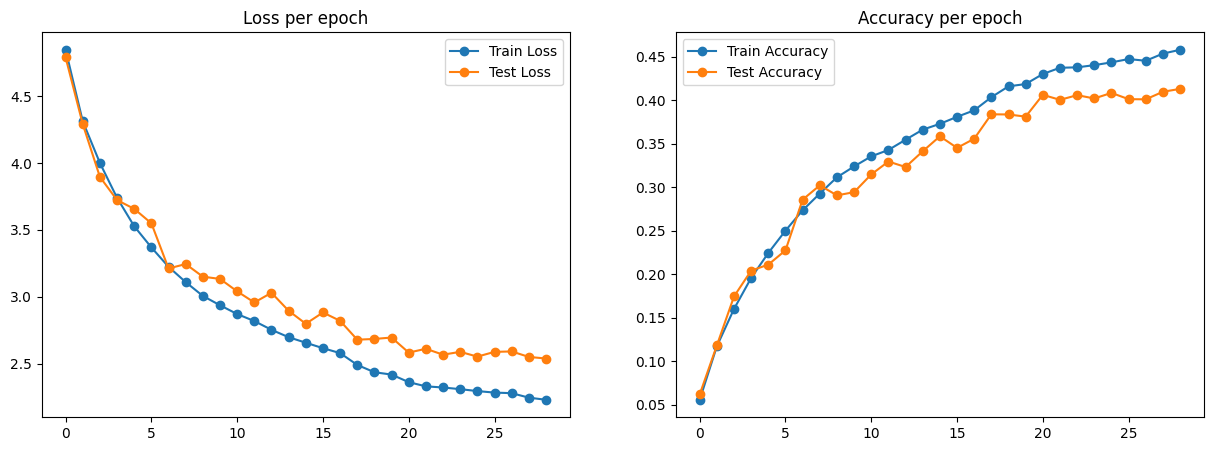

Saving best model

 		 ------------------------------ EPOCH: 30 ------------------------------
[02:08:26] Step 20/22: train loss = 2.23172
Train loss = 2.22997, accuracy = 0.45679, lr: 0.00125
VALIDATION LOSS = 2.52687, VALIDATION ACCURACY = 0.4136
LR: [0.00125]


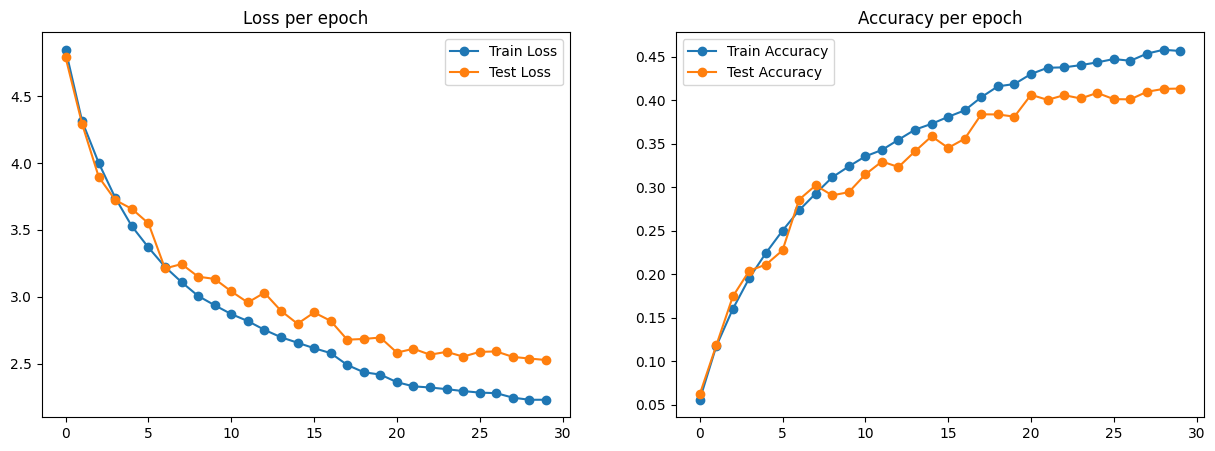

Saving best model

 		 ------------------------------ EPOCH: 31 ------------------------------
[02:09:50] Step 20/22: train loss = 2.21966
Train loss = 2.22329, accuracy = 0.45717, lr: 0.00125
VALIDATION LOSS = 2.54874, VALIDATION ACCURACY = 0.4088
LR: [0.00125]


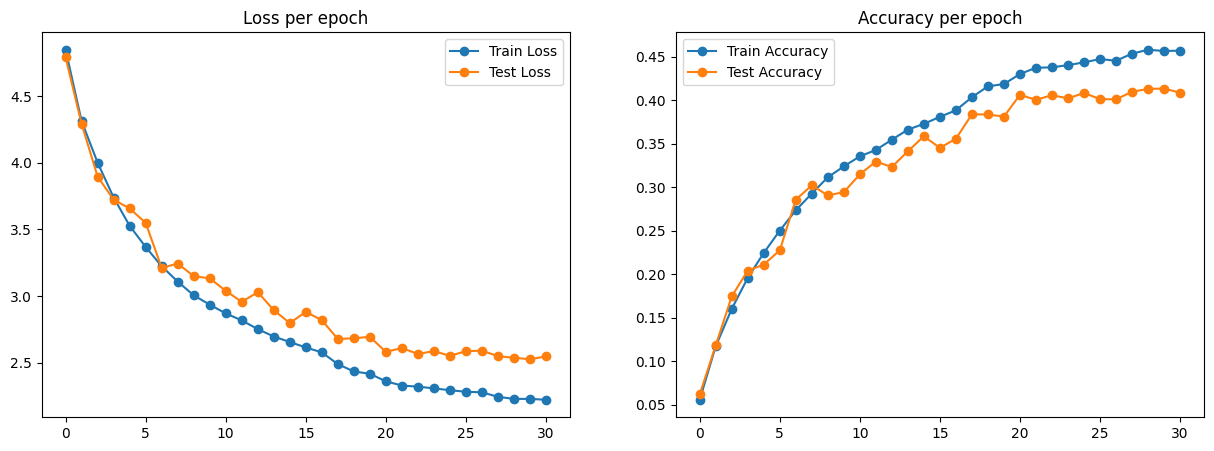

Validation loss didn't improve

 		 ------------------------------ EPOCH: 32 ------------------------------
[02:11:33] Step 20/22: train loss = 2.20911
Train loss = 2.21152, accuracy = 0.46021, lr: 0.00125
VALIDATION LOSS = 2.54234, VALIDATION ACCURACY = 0.4084
LR: [0.000625]


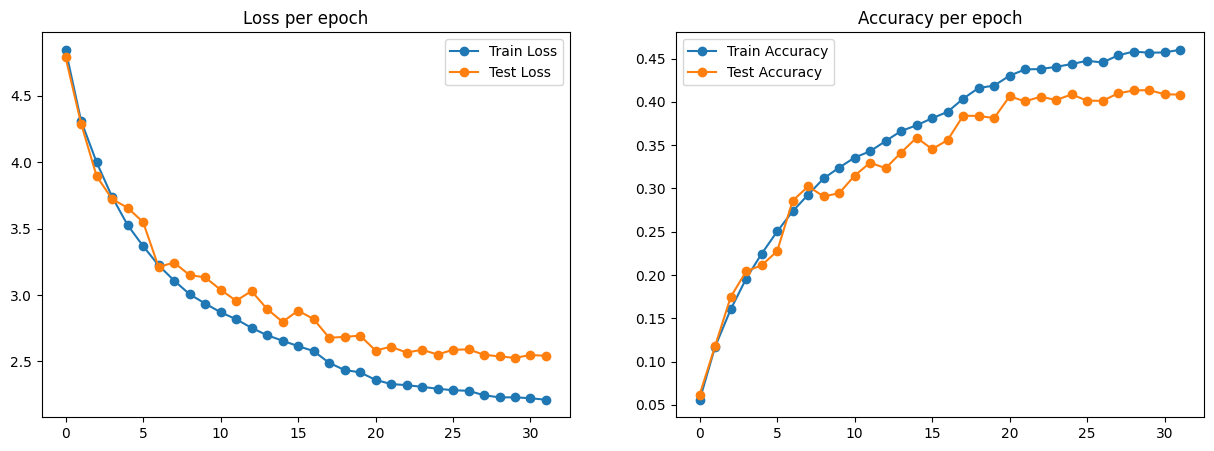

Validation loss didn't improve

 		 ------------------------------ EPOCH: 33 ------------------------------
[02:13:28] Step 20/22: train loss = 2.19576
Train loss = 2.19565, accuracy = 0.46293, lr: 0.000625
VALIDATION LOSS = 2.52142, VALIDATION ACCURACY = 0.4154
LR: [0.000625]


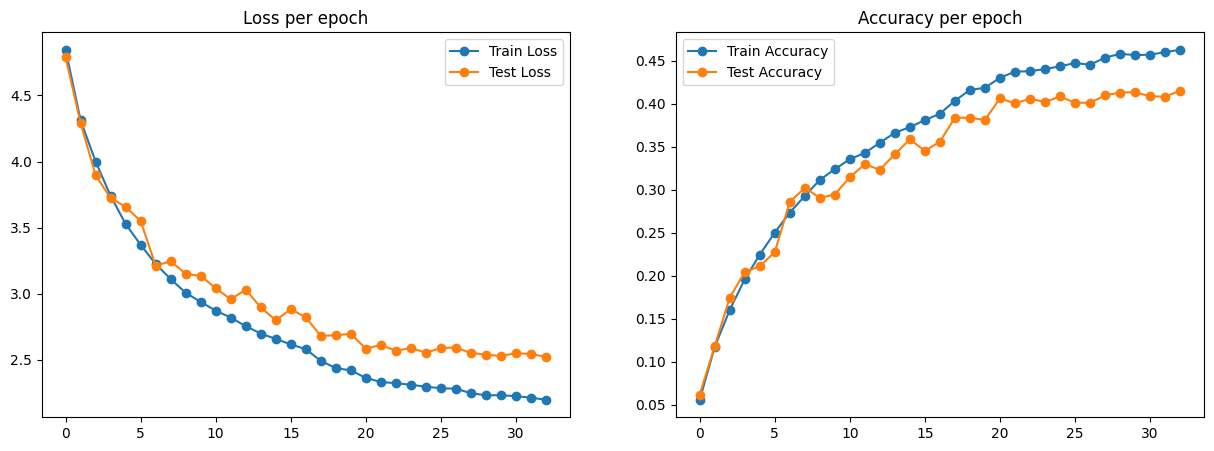

Saving best model

 		 ------------------------------ EPOCH: 34 ------------------------------
[02:14:55] Step 20/22: train loss = 2.19397
Train loss = 2.19142, accuracy = 0.46499, lr: 0.000625
VALIDATION LOSS = 2.5276, VALIDATION ACCURACY = 0.4168
LR: [0.000625]


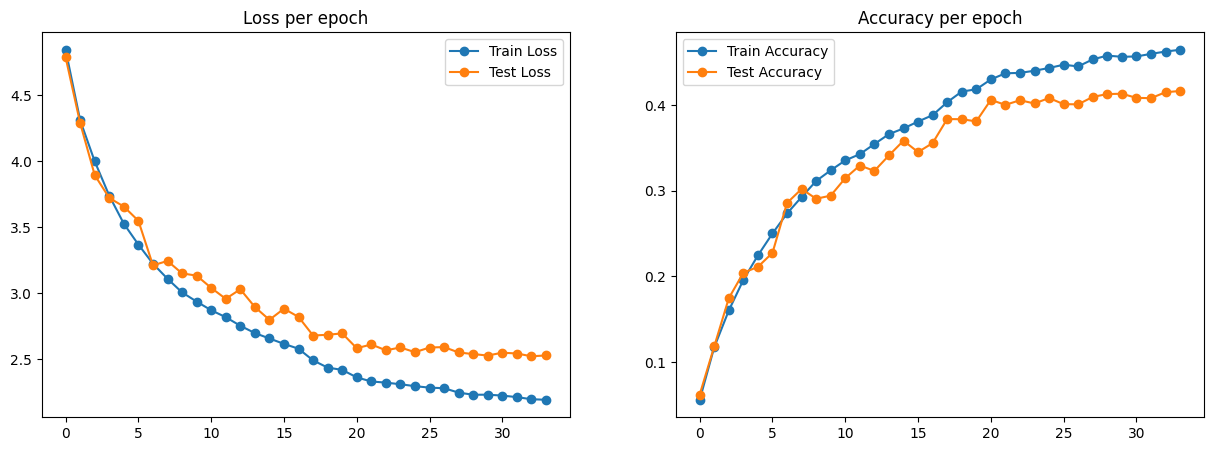

Validation loss didn't improve

 		 ------------------------------ EPOCH: 35 ------------------------------
[02:16:15] Step 20/22: train loss = 2.18472
Train loss = 2.18535, accuracy = 0.46479, lr: 0.000625
VALIDATION LOSS = 2.51153, VALIDATION ACCURACY = 0.4169
LR: [0.000625]


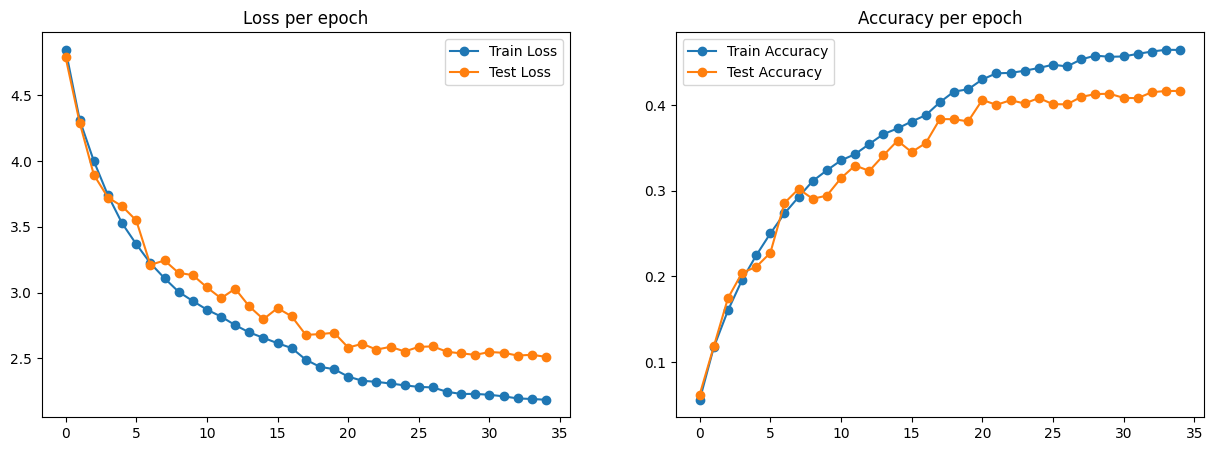

Saving best model

 		 ------------------------------ EPOCH: 36 ------------------------------
[02:17:34] Step 20/22: train loss = 2.17973
Train loss = 2.18093, accuracy = 0.46426, lr: 0.000625
VALIDATION LOSS = 2.51716, VALIDATION ACCURACY = 0.4174
LR: [0.000625]


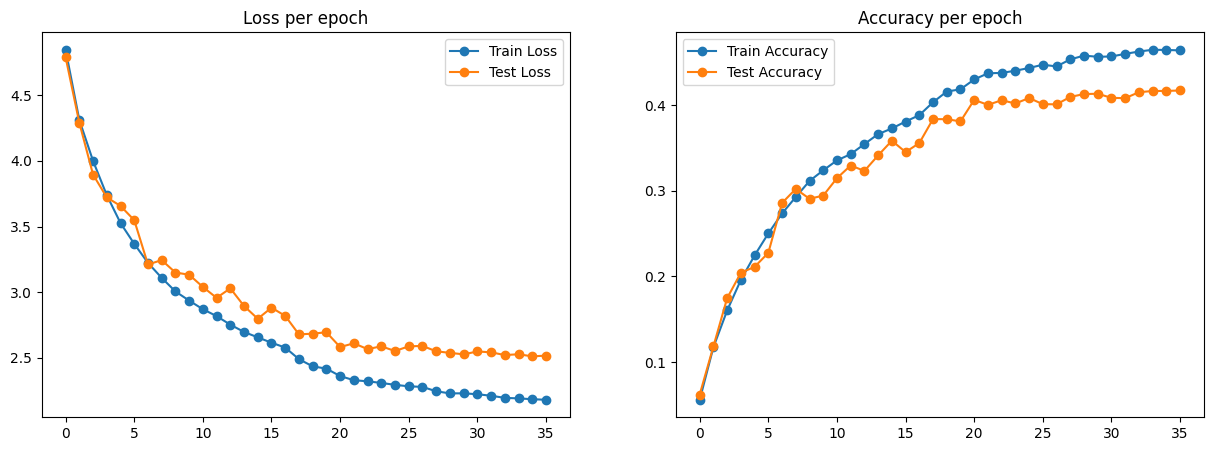

Validation loss didn't improve

 		 ------------------------------ EPOCH: 37 ------------------------------
[02:18:50] Step 20/22: train loss = 2.17801
Train loss = 2.17869, accuracy = 0.46644, lr: 0.000625
VALIDATION LOSS = 2.51614, VALIDATION ACCURACY = 0.4177
LR: [0.0003125]


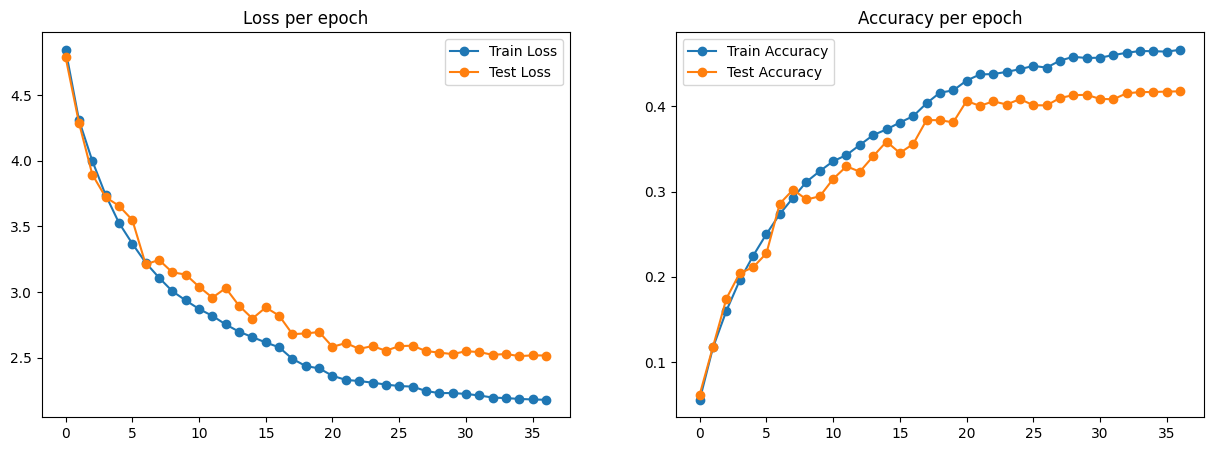

Validation loss didn't improve

 		 ------------------------------ EPOCH: 38 ------------------------------
[02:20:06] Step 20/22: train loss = 2.16947
Train loss = 2.17069, accuracy = 0.46987, lr: 0.0003125
VALIDATION LOSS = 2.50721, VALIDATION ACCURACY = 0.4176
LR: [0.0003125]


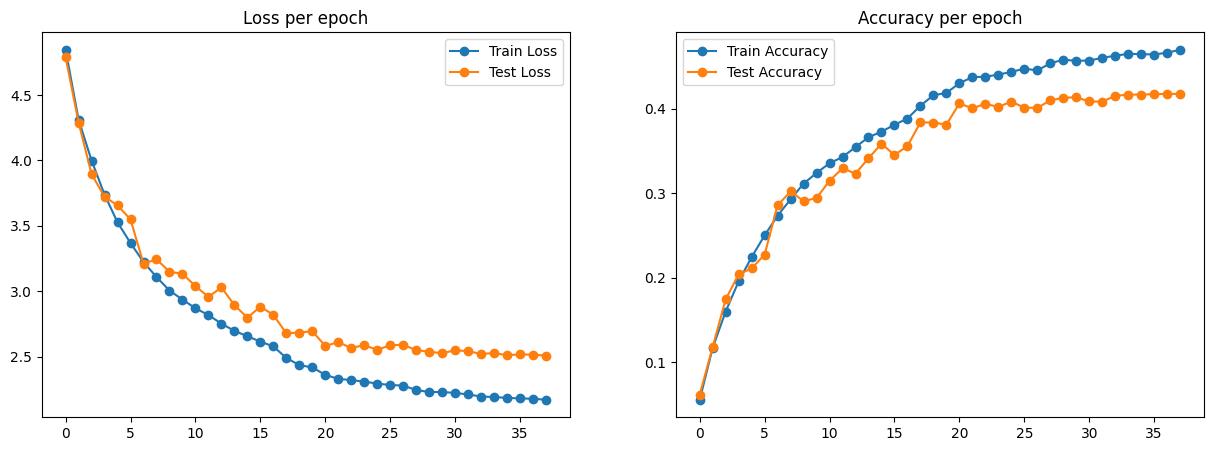

Saving best model

 		 ------------------------------ EPOCH: 39 ------------------------------
[02:21:25] Step 20/22: train loss = 2.17124
Train loss = 2.17044, accuracy = 0.46814, lr: 0.0003125
VALIDATION LOSS = 2.50806, VALIDATION ACCURACY = 0.419
LR: [0.0003125]


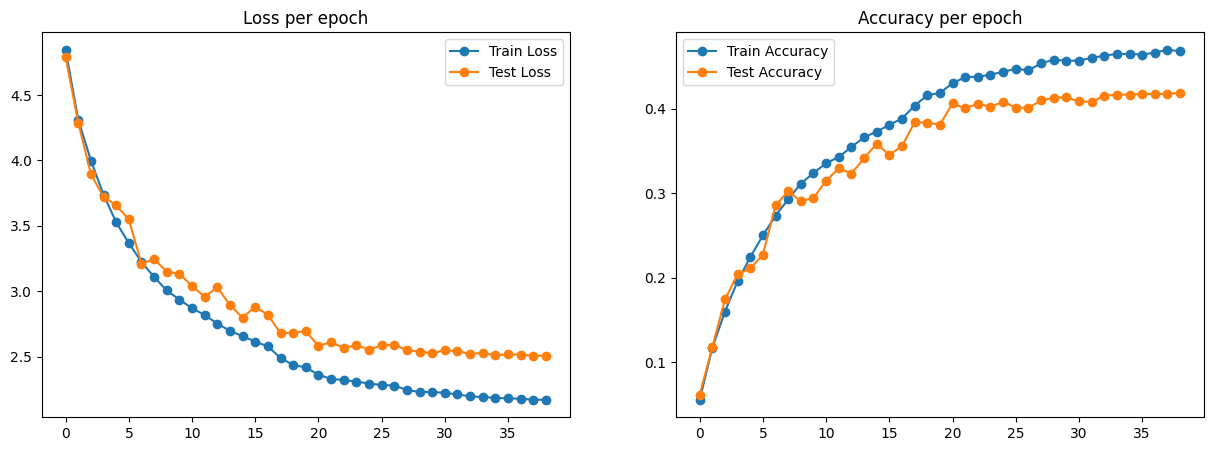

Validation loss didn't improve

 		 ------------------------------ EPOCH: 40 ------------------------------
[02:22:44] Step 20/22: train loss = 2.17078
Train loss = 2.16809, accuracy = 0.46809, lr: 0.0003125
VALIDATION LOSS = 2.50819, VALIDATION ACCURACY = 0.4161
LR: [0.00015625]


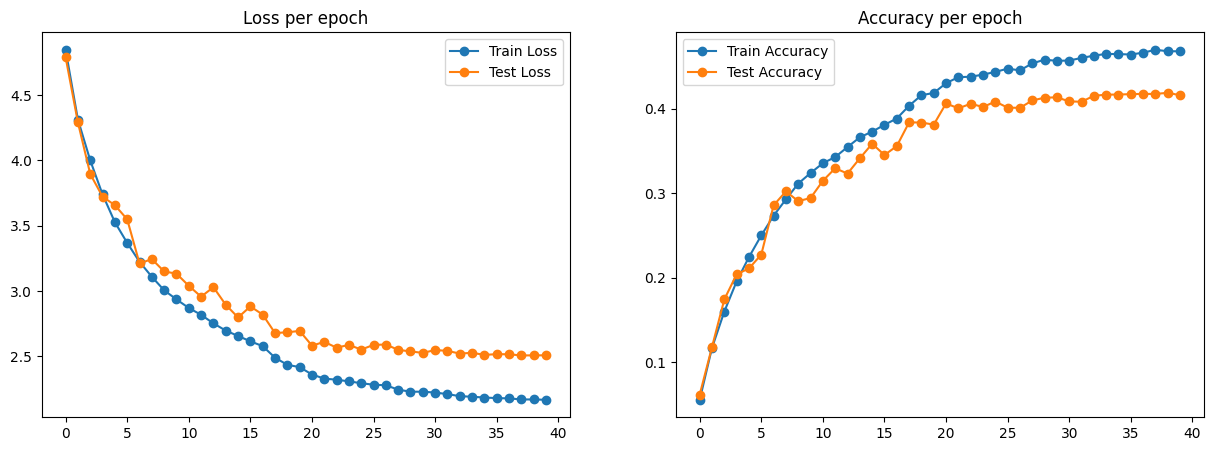

Validation loss didn't improve

 		 ------------------------------ EPOCH: 41 ------------------------------
[02:24:02] Step 20/22: train loss = 2.16693
Train loss = 2.16486, accuracy = 0.46986, lr: 0.00015625
VALIDATION LOSS = 2.50775, VALIDATION ACCURACY = 0.4197
LR: [0.00015625]


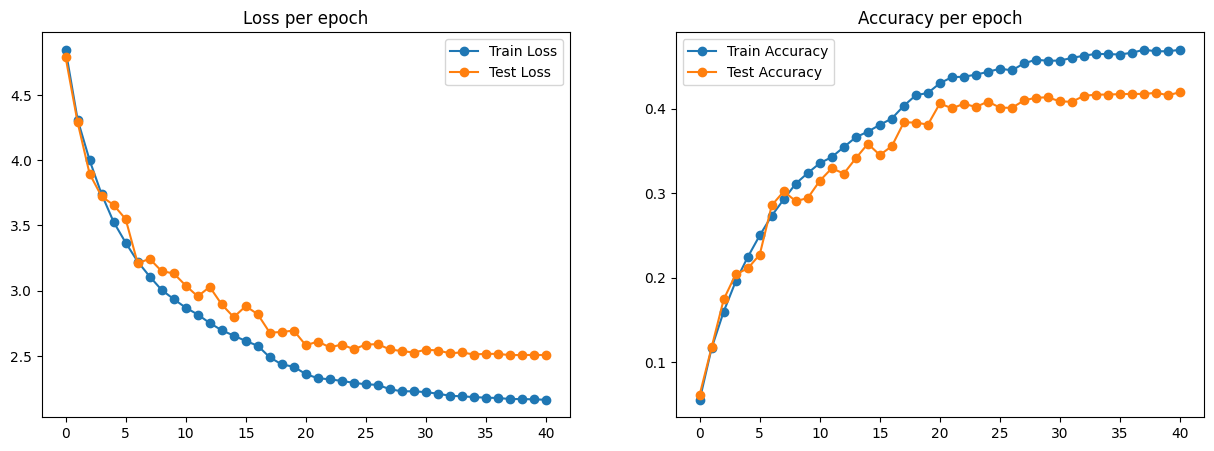

Validation loss didn't improve
EARLY STOPPING: min test_loss 2.50721, last 2 epochs min: 2.50775
Restoring the model at epoch 36: test_accuracy = 0.4176
Model successfully restored

 Training time: 58.0 minutes 42.9 seconds

 Final model is stored to model_epoch_37_test_acc_0.4176.pth


In [22]:
history = {
    'train_loss': [],
    'train_accuracy': [],
    'test_loss': [],
    'test_accuracy': [],
    
}
t1 = monotonic()
for epoch in range(train_config['n_epochs']):
    print('\n', '\t\t', '-' * 30, f"EPOCH: {epoch + 1}", '-' * 30)

    # Train
    model.train()
    model.to(DEVICE)
    train_avg_loss, train_accuracy = do_train_epoch(model, 
                                                    criterion, 
                                                    optimizer, 
                                                    train_dataloader, 
                                                    verbose=20)

    history['train_loss'].append(train_avg_loss)
    history['train_accuracy'].append(train_accuracy)

    # Val
    model.eval()
    val_avg_loss, val_accuracy = do_val_epoch(model, 
                                              criterion, 
                                              val_dataloader)
    scheduler.step(val_avg_loss)
    print(f"LR: {scheduler.get_last_lr()}")
    history['test_loss'].append(val_avg_loss)
    history['test_accuracy'].append(val_accuracy)

    # on_epoch_end events
    plot_history(history)
    
    # model checkpointing
    if history['test_loss'][-1] == min(history['test_loss']):
        print('Saving best model')
        torch.save(model.state_dict(), best_checkpoint_path)
    else:
        print("Validation loss didn't improve")

    # early stopping
    if min(history['test_loss'][-3:]) > min(history['test_loss']):
        best_epoch = np.argmin(history['test_loss'])
        best_test_accuracy = history['test_accuracy'][best_epoch]

        print(f'EARLY STOPPING: min test_loss {min(history["test_loss"])}, last 2 epochs min: {min(history["test_loss"][-3:])}')
        print(f'Restoring the model at epoch {best_epoch - 1}: test_accuracy = {best_test_accuracy}')

        model.load_state_dict(torch.load(best_checkpoint_path, weights_only=True))
        print('Model successfully restored')
        break
    # if epoch == 10:
    #     for g in optimizer.param_groups:
    #         g['lr'] = 0.001
t2 = monotonic()
m, s = divmod(t2 - t1, 60)
    # lr_adjustments (todo)


# saving the best model to hard storage
model_file_name = f'model_epoch_{best_epoch}_test_acc_{best_test_accuracy}.pth'
torch.save(model.state_dict(), f'../working/{model_file_name}')

print(f'\n Training time: {m} minutes {round(s, 2)} seconds')
print(f'\n Final model is stored to {model_file_name}')
os.remove(best_checkpoint_path)

### Make a prediction and prepare submission file

In [23]:
import pandas as pd

In [24]:
class TestDataset(Dataset):
    def __init__(self, 
                 img_dir: str, 
                 file_names: list[str],
                 transform=None):
        self.img_dir = img_dir
        self.file_names = file_names
        self.image_ids = [int(n.split('.')[0].split('_')[1]) for n in file_names]
        self.transform = transform

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        img_path = os.path.join(self.img_dir, file_name)
        image = Image.open(img_path).convert('RGB')

        img_id = self.image_ids[idx]
        
        if self.transform:
            image = self.transform(image)
        return image, img_id

In [25]:
test_folder = '../input/flg-ml-24-cnn/tiny-imagenet-200/val'
test_image_names = sorted(os.listdir(f'{test_folder}/images'))
len(test_image_names)

10000

In [26]:
test_dataset = TestDataset(f'{test_folder}/images', test_image_names, transform=val_img_transform)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=128)

In [27]:
model.eval()

test_predictions = pd.Series([-1] * len(test_dataset))

total_steps = len(test_dataloader)
step = 0

with torch.no_grad():
    for X, img_ids in test_dataloader:
        preds = model(X.to(DEVICE)).cpu()
        
        probs = F.softmax(preds, dim=1)
        predicted_labels = torch.argmax(probs, dim=1)

        # predicted_labels = torch.tensor([0] * X.shape[0])

        test_predictions.loc[img_ids] = predicted_labels.numpy()
        step += 1

        if step % 10 == 0:
            cur_time = datetime.now().strftime("%H:%M:%S")
            print(f"[{cur_time}] Step {step}/{total_steps} done")

[02:24:13] Step 10/79 done
[02:24:14] Step 20/79 done
[02:24:14] Step 30/79 done
[02:24:14] Step 40/79 done
[02:24:15] Step 50/79 done
[02:24:15] Step 60/79 done
[02:24:16] Step 70/79 done


In [28]:
test_predictions_df = (test_predictions
                       .reset_index()
                       .rename(columns={'index': 'ID', 0: 'class'}))
test_predictions_df.head()

,ID,class
0,0,62
1,1,174
2,2,31
3,3,29
4,4,164


In [29]:
# here we will do some analysis to ensure predictions file looks reasonable
(test_predictions_df['class'] < 0).sum()

np.int64(0)

In [30]:
test_predictions_df['class'].value_counts()

class
107    80
111    79
94     77
165    74
156    73
       ..
167    25
198    23
80     22
127    22
166    16
Name: count, Length: 200, dtype: int64

In [31]:
test_predictions_df['class'] = test_predictions_df['class'].map(class_id_to_name_dict)
test_predictions_df['ID'] = test_predictions_df['ID'].apply(lambda v: f'val_{v}.JPEG')

In [32]:
test_predictions_df.head()

,ID,class
0,val_0.JPEG,n03444034
1,val_1.JPEG,n09428293
2,val_2.JPEG,n07614500
3,val_3.JPEG,n04074963
4,val_4.JPEG,n04507155


In [33]:
test_predictions_df.to_csv(f'../working/submission_{model_file_name}.csv', index=False)